In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = '1' # To avoid KMeans memory leak on Windows with MKL userwarning

import seaborn as sns

#### This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

In [2]:
# load data
df =  pd.read_csv('UsArrests.csv', index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


(None,
          Murder     Assault   UrbanPop       Rape
 count  50.00000   50.000000  50.000000  50.000000
 mean    7.78800  170.760000  65.540000  21.232000
 std     4.35551   83.337661  14.474763   9.366385
 min     0.80000   45.000000  32.000000   7.300000
 25%     4.07500  109.000000  54.500000  15.075000
 50%     7.25000  159.000000  66.000000  20.100000
 75%    11.25000  249.000000  77.750000  26.175000
 max    17.40000  337.000000  91.000000  46.000000)

#### From the dataset summary above the following observations can be made
- The dataset contains 50 rows and 5 columns.
- The four variables have vastly different means
- The variables also have vastly different variances 
- UrbanPop variable measures the percentage of the population in each state living in an urban area, which is not a comparable number to the number of murders, rapes or assaults in each state per 100,000 individuals.
- There are no null values to report in the dataset


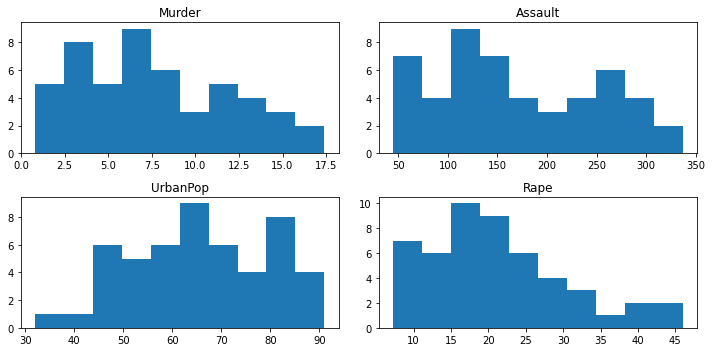

In [4]:
# Plot histograms
df.hist(grid=False, figsize=(10, 5))
plt.tight_layout()
plt.show()

### Crime Rate & Urban Population

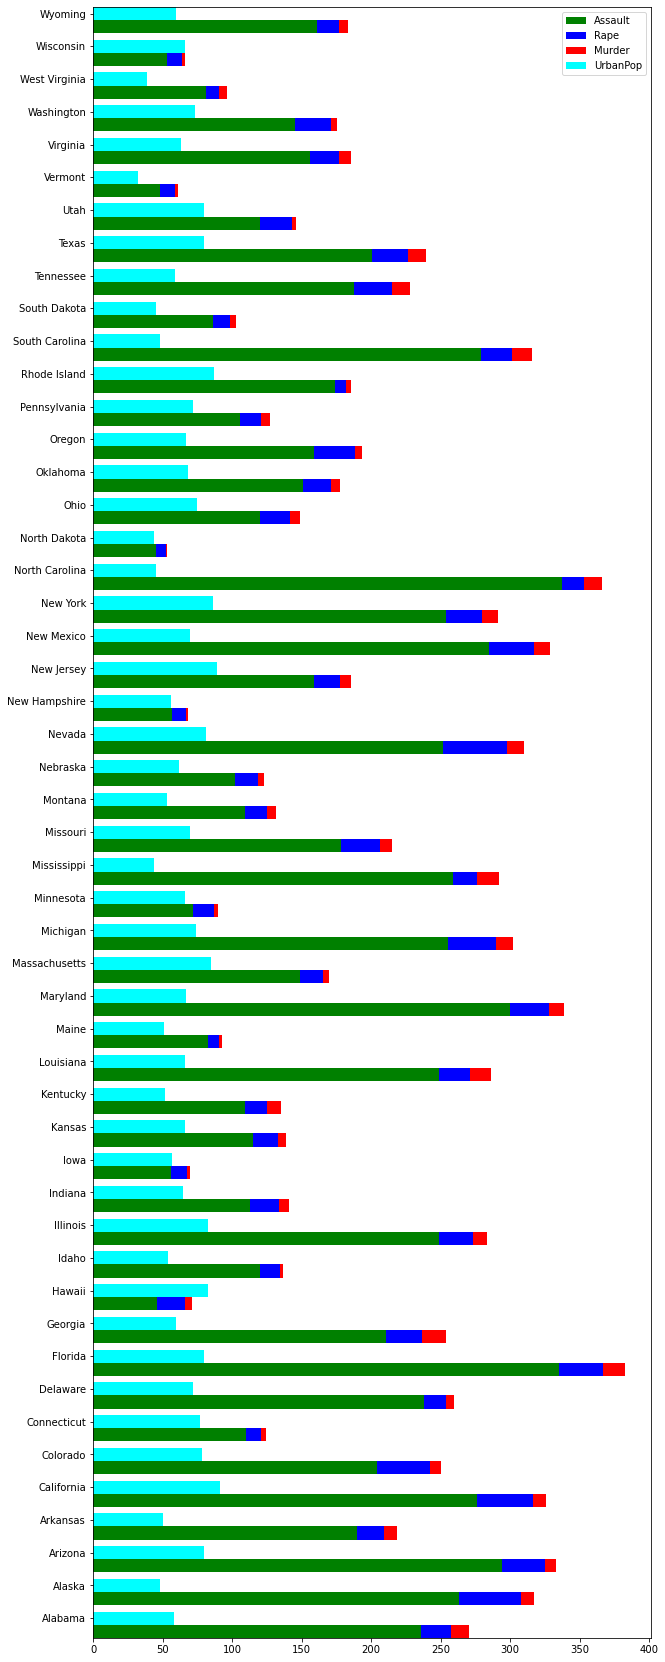

In [5]:
fig, ax = plt.subplots(figsize=(10,30))
y = np.arange(len(df.axes[0]))  # the label locations
bar_height = 0.4  # the height of the bars

# set the position of the bars on the y-axis
bar_positions = y - bar_height

assult = ax.barh(bar_positions, df.Assault, bar_height, color = 'g')
rape = ax.barh(bar_positions, df.Rape, bar_height, color = 'b', left=df.Assault)
murder = ax.barh(bar_positions, df.Murder, bar_height, color = 'r', left=df.Assault+df.Rape)
urbanpop = ax.barh(bar_positions + bar_height, df.UrbanPop, bar_height, color = 'cyan')

ax.set_yticks(y)  # set the y-ticks to be at the same position as the bars
ax.set_yticklabels(df.axes[0])  # set the y-tick labels to be the labels of the dataframe

plt.legend(['Assault','Rape','Murder','UrbanPop'])
plt.margins(y=0)
plt.show()

#### From the bar chart above the following observations can be made
- Highest Assualt Rate : Florida and North California.
- Lowest Assualt Rate : Hawaii, North Dakota, Vermont , New Hampshire and Wisconsin.

- Highest Rape Rate : Nevada and Alaska.
- Lowest Rape Rate : Maine, North Dakota,Vermont,Connecticut,New Hampshire, Wisconsin,Rhode Island and West Virginia

- Highest Murder Rate : Georgia and Missisippi
- Lowest Murder Rate : Idaho , Iowa, Maine, New Hampshire, North Dakota, Vermont and Wisconsin.

- Highest UrbanPop Rate : Nevada and Alaska.
- Lowest UrbanPop Rate : Maine, North Dakota,Vermont,Connecticut,New Hampshire, Wisconsin,Rhode Island and West Virginia


### Correlation Analysis

<AxesSubplot:>

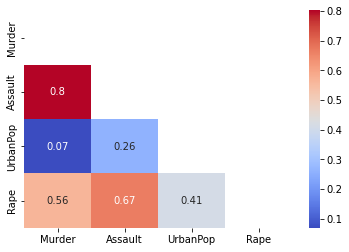

In [6]:
states = df.index
corr_df = df.corr()
labels = corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="coolwarm")

#### From the heat map above the following observations can be made
- Rate of arrests for assault has very strong positive correlation with the rate of arrests for murder.
- Rate of arrests for assault has strong positive correlation with the rate of arrests for rape.
- Rate of arrests for murder has moderate positive correlation with the rate of arrests for rape.
- Urbanpopulation percentage has moderate positive correlation with the rate of arrests for rape.
- Urbanpopulation percentage has weak positive correlation with the rate of arrests for assault.
- Urbanpopulation percentage has almost no correlation with the rate of arrests for murder.

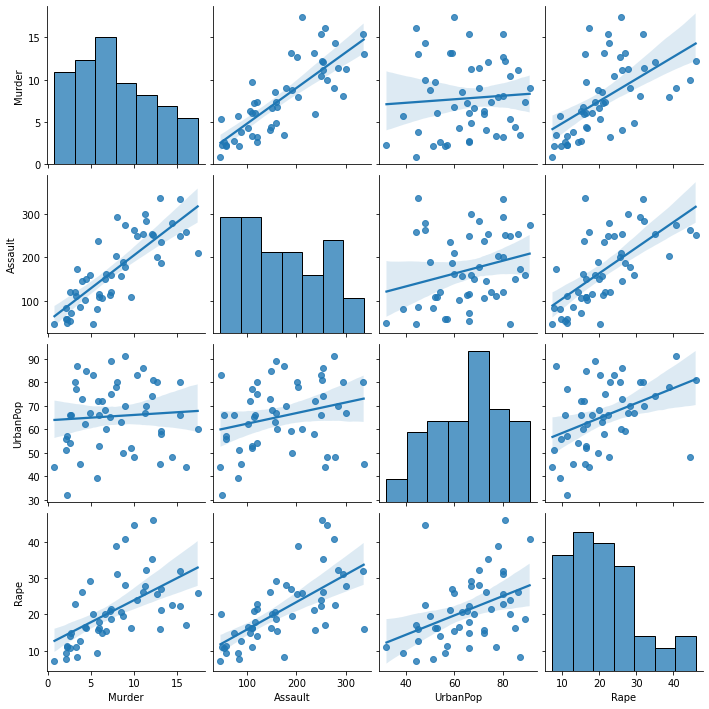

In [7]:
sns.pairplot(df, kind='reg')

#### From the pairplots above the following observations can be made
- Murder , Assault & Rape are highly co-related to each other. 
- UrbanPop is not in co-relation with other variables. 
- Because of the highly co-related input data, PCA can be applied to reduce the number of features.

## PCA

In [8]:
from sklearn.decomposition import PCA
np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [9]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Standard deviation: [83.73 14.21  6.49  2.48]
Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]
Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [10]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15, 15))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

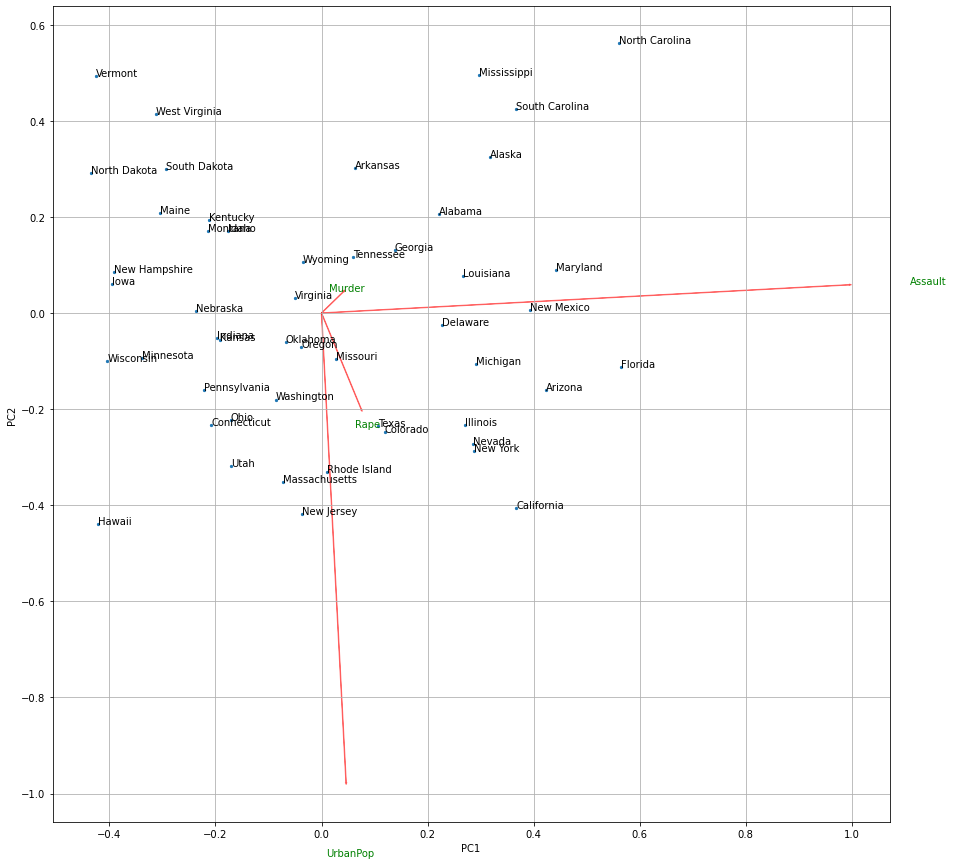

In [11]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

#### Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From this biplot, we see that Assault and UrbanPop are the most important features as the arrows to each of these dominate the biplot.

#### This information can also be quantified as follows:

In [12]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


#### From the table above, it seems that the Assault has by far the highest importance in the first principle component, while UrbanPop has the highest important in the second component. These observations agree with those deduced from the biplot. From the summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

#### Standardised data

Standardise the data so that some features do not swamp the others.

In [13]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


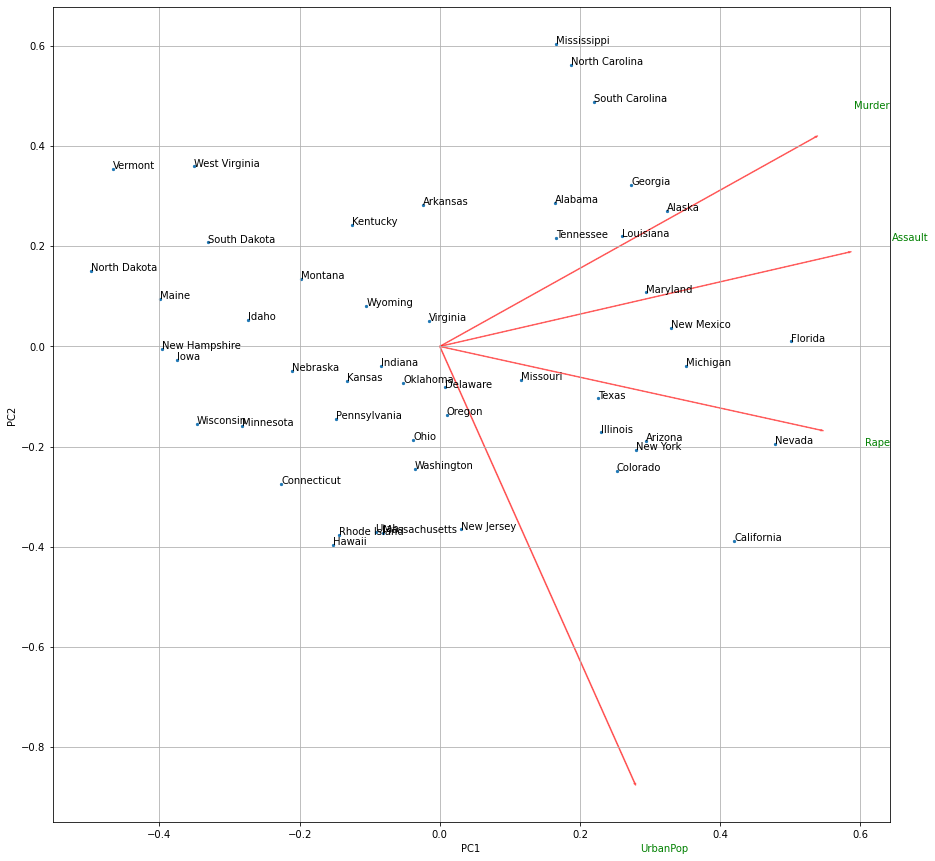

In [14]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

#### In the standardised data results abive, far more variables are being utilised to explain the variance, as the large numbers no longer dominate it. 

In [15]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


#### Inspecting the feature importance now, it seems that most of the variables contribute fairly evenly, with only some with low importance.

Text(0.5, 1.0, 'Cumulative Explained Variance')

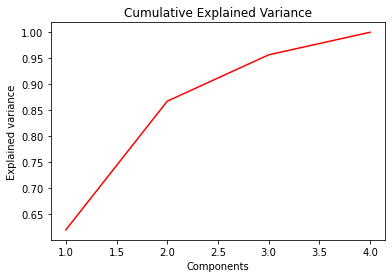

In [16]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

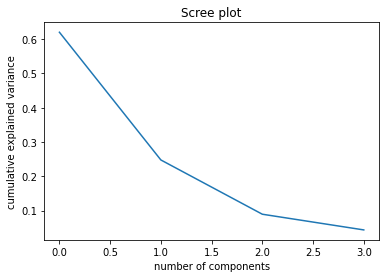

In [17]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

#### From the plots above, it seems the first 3 principal components together explain around 95% of the variance. We can therefore use them to perform cluster analysis. 

In [18]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


## K-Means

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3)

### Determination of the Optimal Number of Clusters

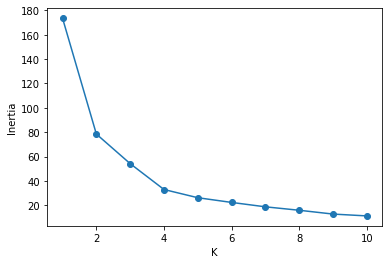

In [20]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)
    return kmeans.inertia_


def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars, marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

x_1 = pca_df[[0,1]]
X = pca_df[[0,1]].values.reshape(-1, 2)
elbow_Kmeans(X)

#### The elbow runs from k=2 to k=4. In cases like this, it is not clear which value within the elbow is the most optimal, so we can investigate likely candidates further using the silhouette score.

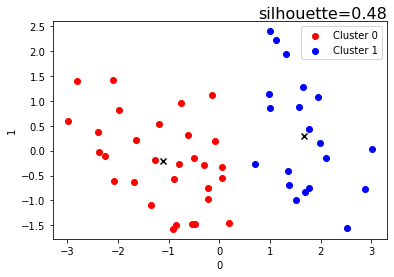

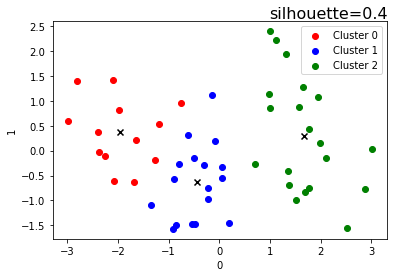

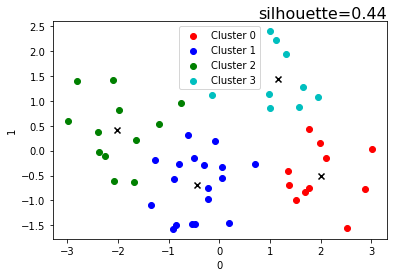

In [21]:
from sklearn.metrics import silhouette_score

def scatter_Kmeans(x, k, r=123):
    ''' This function takes dataframe (x),k and random_state(r) paremeters to build K-Nearest Neighbours model, 
    calculate accuracy of the model and create a scatter plot showing the clusters predicted by the model. 
    '''
    X = x.values.reshape(-1,2)
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(X)
    colours = 'rbgcmy'
    
    for c in range(k):
      plt.scatter(X[y_pred == c, 0], X[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')

    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel(x.axes[1][0])
    plt.ylabel(x.axes[1][1])
    plt.legend()
    plt.show()

for k in range(2,5):
  scatter_Kmeans(x_1, k, r=0)

#### Thus we see that the best silhouette score is actually achieved using k=2.

Text(0, 0.5, 'Dim 1')

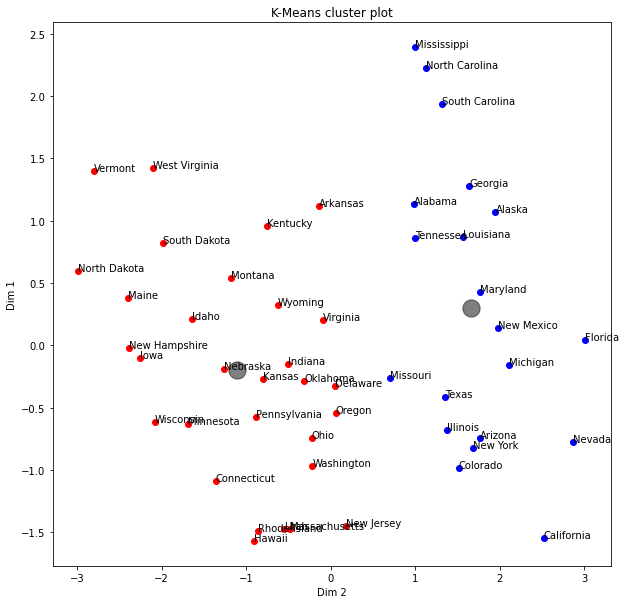

In [22]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i])
    ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='o', c = "black", s=300, alpha=0.5)

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

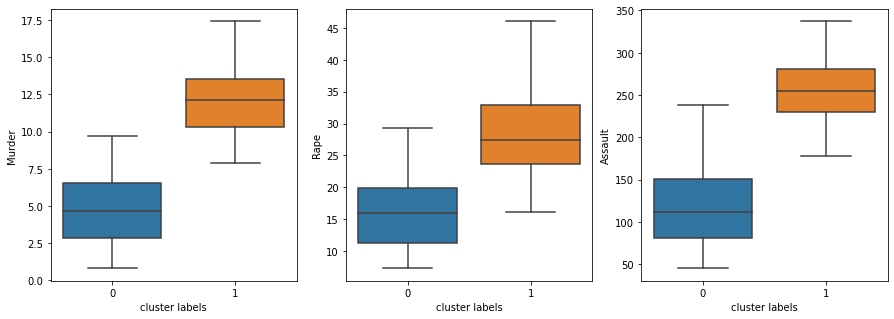

In [23]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

#### From the box plots above, it seems
- The states in Group-0 seems to be Low-risk States where there are relativley less Murders,Assaults and Rapes.
- The states in the Group-1 seems to have higher crime rates and can be regarded as High-risk States.

In [24]:
for i in range(k):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(states)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n")     

Group 0 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


Group 1 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Missouri, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas




## Agglomerative clustering
As with this dataset, the goal of the analysis is to identify the unknown pattern of the data without any prior assumption, agglomerative clustering is a better choice.

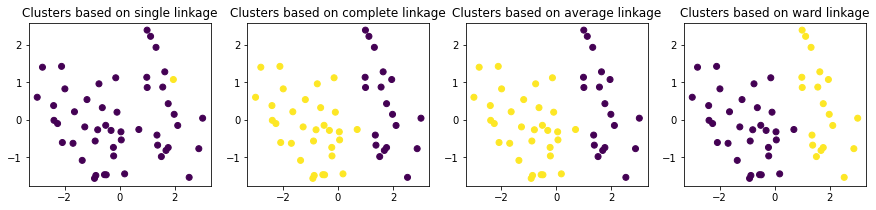

In [25]:
from sklearn.cluster import AgglomerativeClustering

X = pca_df.values.reshape(-1, 3)
linkage_types = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=[15,3])
for i, l in enumerate(linkage_types):
  plt.subplot(1, 4, i+1)
  cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage=l)
  cluster.fit_predict(X)

  ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
  plt.title('Clusters based on {} linkage'.format(l))
 
L = 'complete'

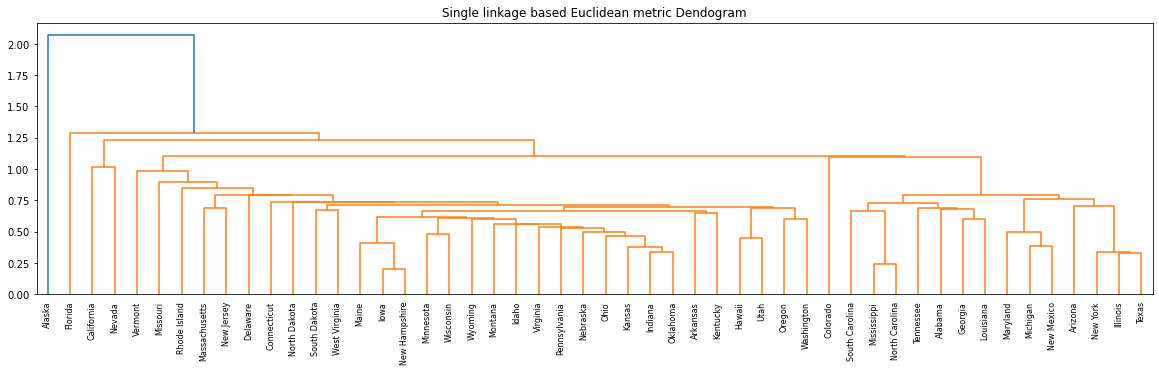

In [26]:
# Visualisation
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,5))
plt.title("Single linkage based Euclidean metric Dendogram")
dend = dendrogram(linkage(X, method='single', metric='euclidean'), labels=pca_df.index)

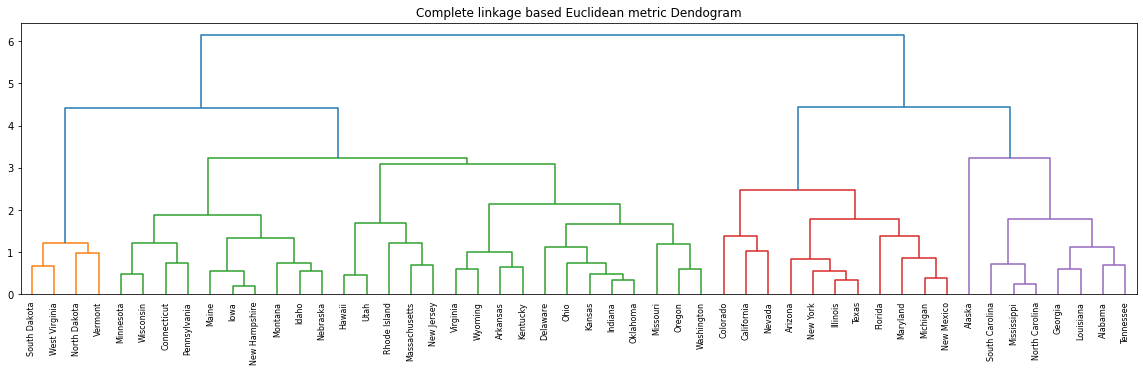

In [27]:
# Print dendogram using complete linkage and euclidean matric
plt.figure(figsize=(20,5))
plt.title("Complete linkage based Euclidean metric Dendogram")
dend = dendrogram(linkage(X, method='complete', metric='euclidean'), labels=pca_df.index)

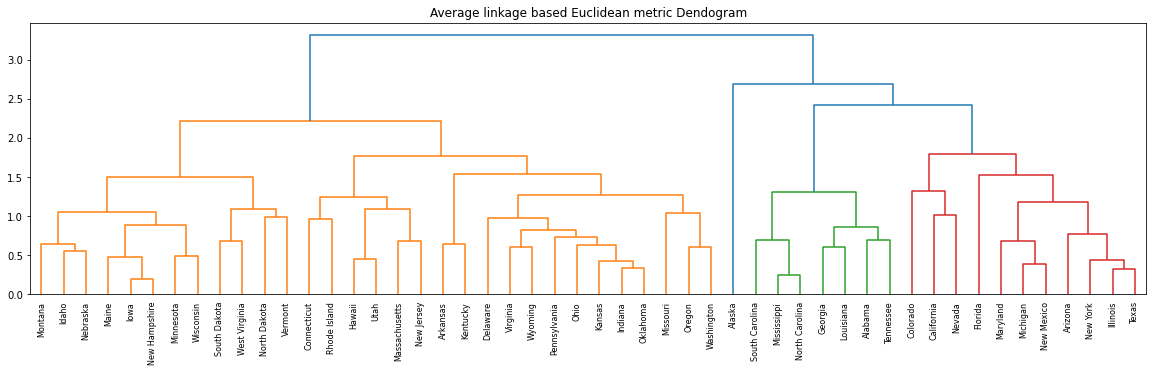

In [28]:
# Print dendogram using average linkage and euclidean matric
plt.figure(figsize=(20,5))
plt.title("Average linkage based Euclidean metric Dendogram")
dend = dendrogram(linkage(X, method='average', metric='euclidean'), labels=pca_df.index)

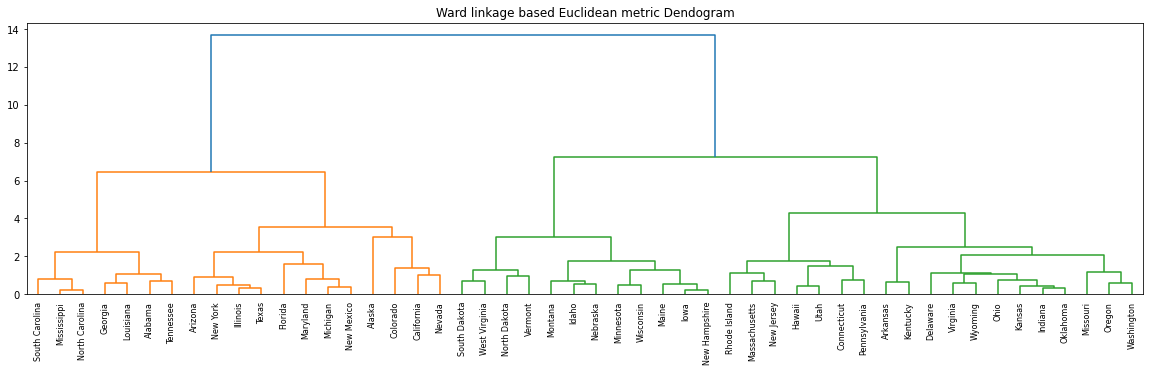

In [29]:
# With Ward method
plt.figure(figsize=(20,5))
plt.title('Ward linkage based Euclidean metric Dendogram')
dend = dendrogram(linkage(X, method  = "ward"), labels=pca_df.index)

#### From the dendrogram above, it seems there are two clusters.

Text(0, 0.5, 'Dim 1')

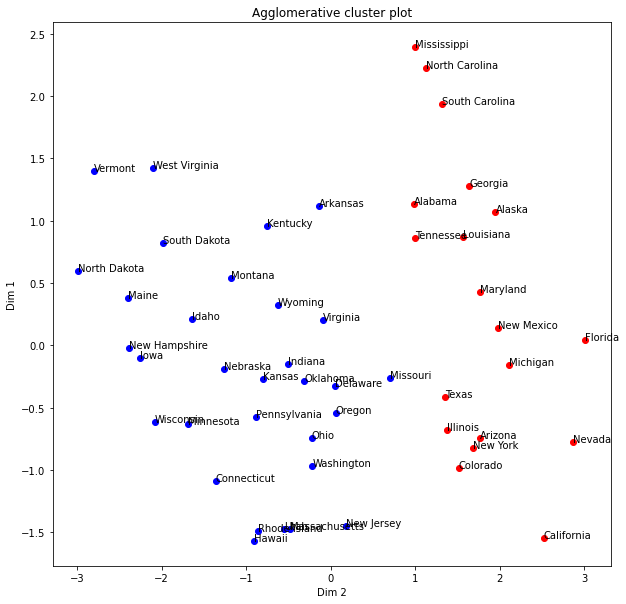

In [30]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Run agglomerative hierarchical clustering with 2 number of clusters, 
#'complete' linkage method and 'euclidean' distance metric used for that dendrogram).
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
cluster_labels = cluster.fit_predict(pca_df)

# Plot clusters
fig, ax = plt.subplots(figsize=(10,10))
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("Agglomerative cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

In [31]:
# Verify the clusters obtained by using the Silhouette score 
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=1)
y_pred = kmeans.fit_predict(X)
score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)
score

0.43

<AxesSubplot:xlabel='cluster labels', ylabel='Assault'>

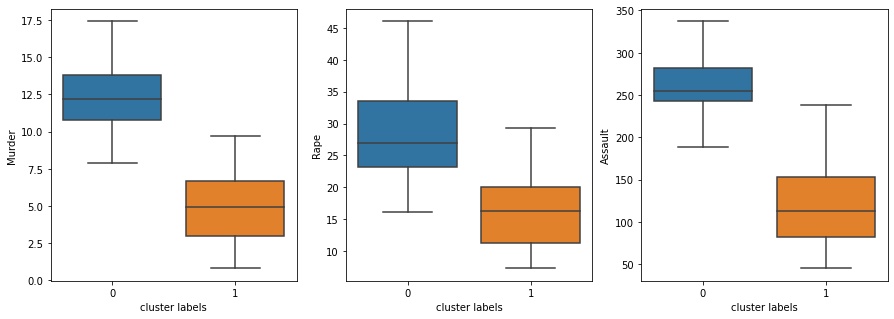

In [32]:
# Boxplots to display distribution of crime rates for the states in cluster 0 and cluster 1.
df['cluster labels']=cluster_labels
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x='cluster labels', y='Murder', data=df, ax=ax[0])
sns.boxplot(x='cluster labels', y='Rape', data=df, ax=ax[1])
sns.boxplot(x='cluster labels', y='Assault', data=df, ax=ax[2])

#### From the box plots above, it seems
- The states in the Group-0 seems to have higher crime rates and can be regarded as High-risk States.
- The states in Group-1 seems to be Low-risk States where there are relativley less Murders,Assaults and Rapes.

In [33]:
for i in range(k):
    group_indices = np.argwhere(cluster_labels==i).transpose()[0]
    group = np.array(states)[group_indices]
    print(f'Group {i} States:', *group, sep=", ")
    print("\n")

Group 0 States:, Alabama, Alaska, Arizona, California, Colorado, Florida, Georgia, Illinois, Louisiana, Maryland, Michigan, Mississippi, Nevada, New Mexico, New York, North Carolina, South Carolina, Tennessee, Texas


Group 1 States:, Arkansas, Connecticut, Delaware, Hawaii, Idaho, Indiana, Iowa, Kansas, Kentucky, Maine, Massachusetts, Minnesota, Missouri, Montana, Nebraska, New Hampshire, New Jersey, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Dakota, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming


